In [1]:
# import yfinance as yf
# import pandas as pd

# # Download GOOG stock data at 5-minute intervals for the past 30 days
# df = yf.download(tickers='GOOG', period='30d', interval='5m')

# # Flatten columns if multi-indexed
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = df.columns.get_level_values(0)

# # Convert index (Datetime) from UTC to US/Eastern
# df.index = df.index.tz_convert('US/Eastern')

# # Preview the DataFrame
# print(df.head())

# # Optional: Save to CSV
# df.to_csv('goog_30days_5min.csv')

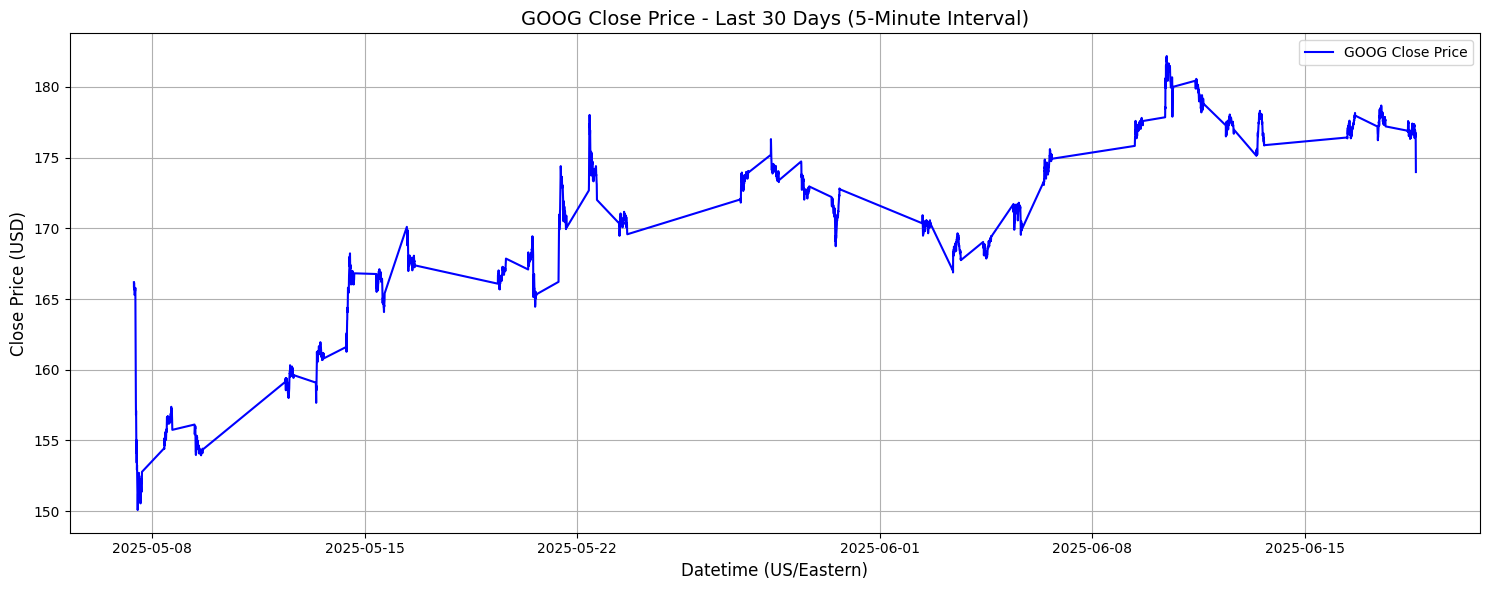

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV and parse the datetime column
df = pd.read_csv('goog_30days_5min.csv', parse_dates=['Datetime'], index_col='Datetime')

# Plot Datetime vs Close
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='GOOG Close Price', color='blue')
plt.title('GOOG Close Price - Last 30 Days (5-Minute Interval)', fontsize=14)
plt.xlabel('Datetime (US/Eastern)', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 0.030214
Epoch 2/10, Loss: 0.023664
Epoch 3/10, Loss: 0.008734
Epoch 4/10, Loss: 0.005143
Epoch 5/10, Loss: 0.004354
Epoch 6/10, Loss: 0.004015
Epoch 7/10, Loss: 0.004178
Epoch 8/10, Loss: 0.003066
Epoch 9/10, Loss: 0.003071
Epoch 10/10, Loss: 0.004181


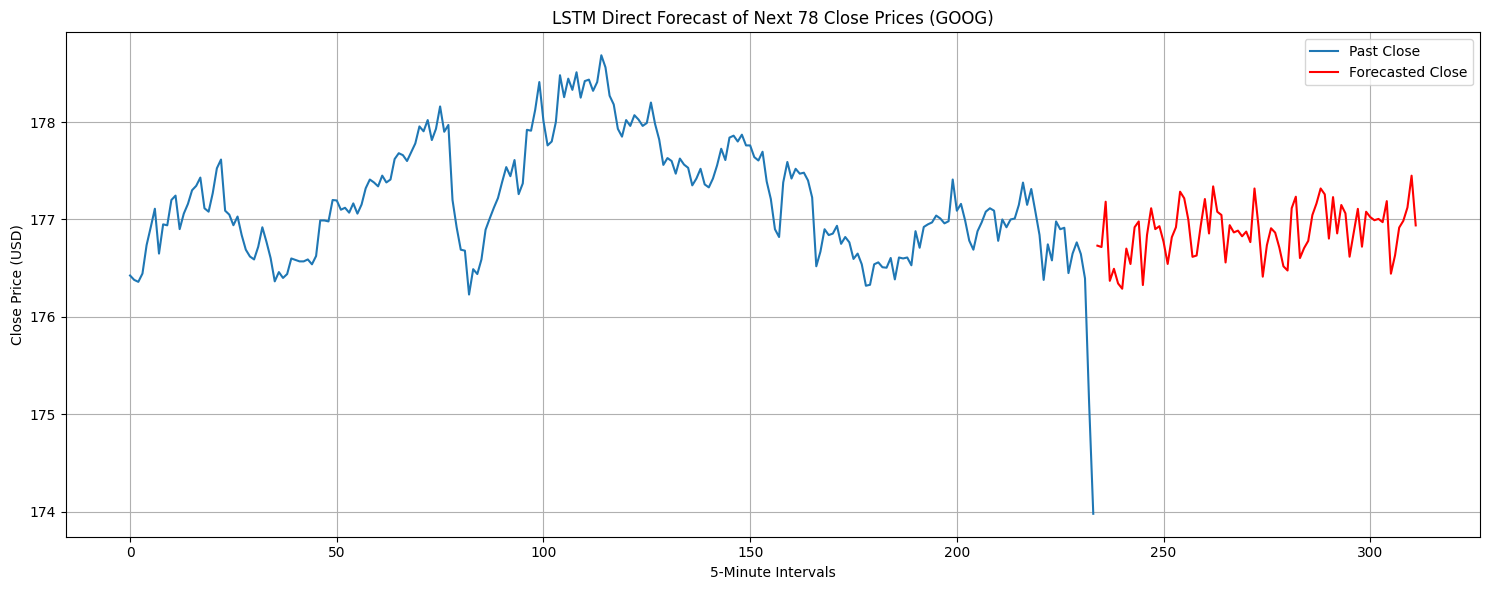

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Step 1: Load and preprocess
# -----------------------------
df = pd.read_csv("goog_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')
close_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# -----------------------------
# Step 2: Prepare sequences
# -----------------------------
INPUT_LEN = 78 * 3  # past 3 trading days
OUTPUT_LEN = 78     # forecast next 1 trading day (5-minute steps)

X = []
Y = []

for i in range(len(scaled_close) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_close[i:i+INPUT_LEN])
    Y.append(scaled_close[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN])

X = np.array(X)
Y = np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)  # shape: (N, 234, 1)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # shape: (N, 78)

# -----------------------------
# Step 3: Define LSTM model
# -----------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_len=78):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)           # out: (batch, seq_len, hidden)
        out = out[:, -1, :]             # use last time step's output
        out = self.fc(out)              # project to output_len (78)
        return out

# Instantiate model
model = LSTMForecast()

# -----------------------------
# Step 4: Training loop
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i + BATCH_SIZE]
        batch_x = X_tensor[indices]
        batch_y = Y_tensor[indices]

        output = model(batch_x)
        loss = criterion(output, batch_y.squeeze(-1))  # 🔧 Fix here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -----------------------------
# Step 5: Forecast next 78 steps
# -----------------------------
model.eval()  # 🔍 Set model to evaluation mode
last_input = torch.tensor(scaled_close[-INPUT_LEN:], dtype=torch.float32).unsqueeze(0)  # (1, 234, 1)

with torch.no_grad():  # 🔒 No gradient tracking
    forecast_scaled = model(last_input).numpy().flatten()

forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# -----------------------------
# Step 6: Plot the forecast
# -----------------------------
past_close = close_prices[-INPUT_LEN:].flatten()

plt.figure(figsize=(15, 6))
plt.plot(range(INPUT_LEN), past_close, label='Past Close')
plt.plot(range(INPUT_LEN, INPUT_LEN + OUTPUT_LEN), forecast, label='Forecasted Close', color='red')
plt.xlabel('5-Minute Intervals')
plt.ylabel('Close Price (USD)')
plt.title('LSTM Direct Forecast of Next 78 Close Prices (GOOG)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 0.031581
Epoch 2/10, Loss: 0.018066
Epoch 3/10, Loss: 0.004055
Epoch 4/10, Loss: 0.003041
Epoch 5/10, Loss: 0.003784
Epoch 6/10, Loss: 0.003049
Epoch 7/10, Loss: 0.003344
Epoch 8/10, Loss: 0.002968
Epoch 9/10, Loss: 0.002711
Epoch 10/10, Loss: 0.002961


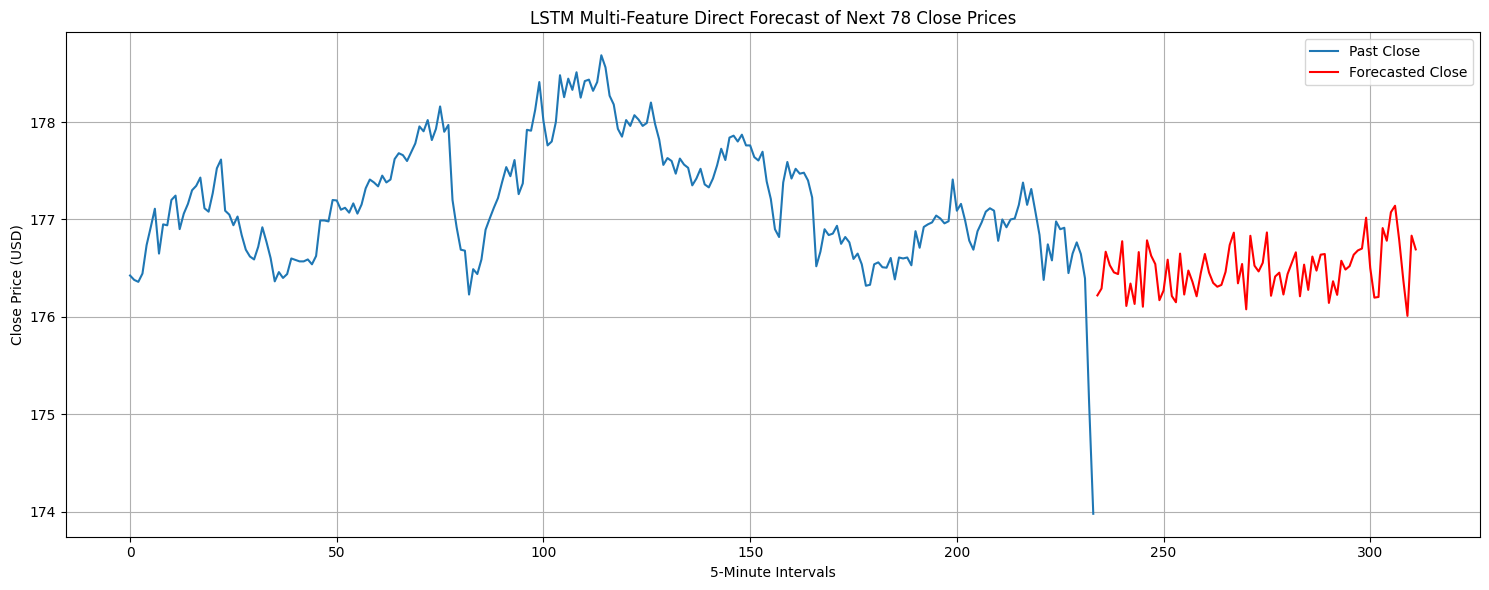

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# -------------------------------------
# Step 1: Load and preprocess the data
# -------------------------------------
df = pd.read_csv("goog_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')
features = ['Close', 'High', 'Low', 'Open', 'Volume']
data = df[features].values

# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Save index of Close column for inverse transform later
close_index = features.index('Close')

# -------------------------------------
# Step 2: Prepare sequences
# -------------------------------------
INPUT_LEN = 78*3   # past 3 trading day
OUTPUT_LEN = 78  # future 1 trading day (5-minute steps)

X = []
Y = []

for i in range(len(scaled_data) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_data[i:i+INPUT_LEN])
    # Only take Close column (index 0) from the next 78 steps
    Y.append(scaled_data[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN, close_index])

X = np.array(X)
Y = np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)       # (N, 234, 5)
Y_tensor = torch.tensor(Y, dtype=torch.float32)       # (N, 78)

# -------------------------------------
# Step 3: Define the LSTM model
# -------------------------------------
class MultiFeatureLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_len=78):
        super(MultiFeatureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)          # out: (batch, time, hidden)
        out = out[:, -1, :]            # use last time step's hidden state
        out = self.fc(out)             # project to 78 output values
        return out

model = MultiFeatureLSTM()

# -------------------------------------
# Step 4: Training loop
# -------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x = X_tensor[indices]
        batch_y = Y_tensor[indices]

        output = model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -------------------------------------
# Step 5: Forecast next 78 steps
# -------------------------------------
last_input = torch.tensor(scaled_data[-INPUT_LEN:], dtype=torch.float32).unsqueeze(0)  # shape: (1, 234, 5)

model.eval()
with torch.no_grad():
    forecast_scaled = model(last_input).numpy().flatten()

# Inverse transform only the Close column
# We'll create dummy input for inverse transform
dummy = np.zeros((forecast_scaled.shape[0], len(features)))
dummy[:, close_index] = forecast_scaled
forecast = scaler.inverse_transform(dummy)[:, close_index]

# -------------------------------------
# Step 6: Plot the forecast
# -------------------------------------
past_close = data[-INPUT_LEN:, close_index]

plt.figure(figsize=(15, 6))
plt.plot(range(INPUT_LEN), past_close, label='Past Close')
plt.plot(range(INPUT_LEN, INPUT_LEN + OUTPUT_LEN), forecast, label='Forecasted Close', color='red')
plt.xlabel('5-Minute Intervals')
plt.ylabel('Close Price (USD)')
plt.title('LSTM Multi-Feature Direct Forecast of Next 78 Close Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()